In [92]:
import numpy as np
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
from scipy import stats
from keras.preprocessing import sequence

In [47]:
def flatten(x):
    if isinstance(x, (np.ndarray, list, tuple, pd.Series)):
        lst = []
        for i in x:
            lst += flatten(i)
        return lst
    else:
        return [x]

#### Load Data

In [5]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [69]:
train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


In [27]:
train['tokens'] = train['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))
test['tokens'] = test['comment_text'].apply(lambda x: list(filter(lambda z: len(z), map(lambda y: y.lower(), nltk.word_tokenize(x)))))

In [31]:
train['tokens'].head()

0    [explanation, why, the, edits, made, under, my...
1    [d'aww, !, he, matches, this, background, colo...
2    [hey, man, ,, i, 'm, really, not, trying, to, ...
3    [``, more, i, ca, n't, make, any, real, sugges...
4    [you, ,, sir, ,, are, my, hero, ., any, chance...
Name: tokens, dtype: object

In [32]:
train['tokLength'] = train['tokens'].apply(lambda x: len(x))

In [36]:
train['tokLength'].describe()

count    159571.000000
mean         80.322201
std         120.769777
min           1.000000
25%          20.000000
50%          43.000000
75%          89.000000
max        4948.000000
Name: tokLength, dtype: float64

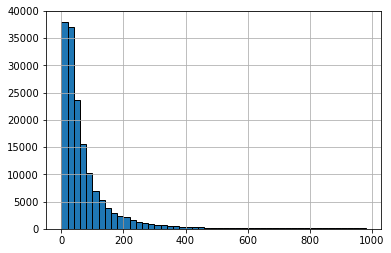

In [41]:
train['tokLength'].hist(bins = range(0, 1000, 20),linewidth = 1, edgecolor = 'black' )
plt.show()
#looks like max_length of 500 should be good

In [43]:
stats.percentileofscore(train['tokLength'].values, 500)

98.256575442906296

In [44]:
max_length = 500

What are the most common words in the texts?

In [64]:
dist = nltk.FreqDist(flatten(train.tokens.values))

In [65]:
print('Number of total tokens in the training set:', dist.N())
print('Number of unique tokens in the training set:', dist.B())

Number of total tokens in the training set: 12817094
Number of unique tokens in the training set: 259285


In [66]:
dist.most_common(n=50)

[('.', 502031),
 ('the', 495401),
 (',', 471812),
 ('to', 296851),
 ("''", 242526),
 ('i', 236559),
 ('of', 224008),
 ('and', 222709),
 ('you', 216674),
 ('a', 214116),
 ('is', 180287),
 ('that', 160512),
 ('``', 155372),
 ('it', 147625),
 ('in', 144392),
 ('!', 105576),
 ('for', 102451),
 ('this', 96943),
 ('not', 96581),
 (')', 90711),
 ('on', 89409),
 ('(', 85085),
 ('be', 83326),
 (':', 82772),
 ('as', 77269),
 ('have', 73939),
 ('are', 73404),
 ('?', 71692),
 ("'s", 66767),
 ('your', 63258),
 ('do', 62602),
 ('with', 59498),
 ('if', 58363),
 ("n't", 57137),
 ('article', 56859),
 ('was', 56537),
 ('or', 52514),
 ('but', 50938),
 ('page', 45656),
 ('my', 45520),
 ('wikipedia', 45418),
 ('an', 44513),
 ('from', 41411),
 ('by', 41040),
 ('at', 39430),
 ('can', 37244),
 ('about', 37043),
 ('me', 37025),
 ('so', 35968),
 ('what', 35291)]

#### Load GloVe

In [10]:
f = open('data/glove.42B.300d.txt', 'r', encoding = 'utf-8')

In [11]:
embeddings = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype = 'float32')
    embeddings[word] = coefs

In [46]:
np.random.seed(10)
embeddings['<UNK>'] = np.random.normal(scale = 0.6,size = embeddings['.'].shape)

What are the most common words not in the vocab?

In [57]:
notInVocab = []
for i in dist.most_common():
    if i[0] not in embeddings.keys() and i[1]>100:
        notInVocab.append((i[0], i[1]))

In [58]:
notInVocab

[('•', 5300),
 ('==', 3145),
 ('~~~~', 1472),
 ('style=', 1303),
 ('·', 1109),
 ('|-', 868),
 ('*', 730),
 ('f5fffa', 713),
 ('..', 683),
 ('width=', 667),
 ('|style=', 635),
 ('====', 627),
 ('yourselfgo', 621),
 ('—preceding', 540),
 ('border:1px', 523),
 ('//en.wikipedia.org/w/index.php', 471),
 ("'image", 420),
 ('philippineslong', 420),
 ('cellpadding=', 372),
 ('pro-assad.hanibal911you', 345),
 ('bitches.fuck', 333),
 ('deneid', 331),
 ('rice=', 330),
 ('three-revert', 328),
 ("'fuck", 325),
 ('\u200e', 321),
 ('pagedelete', 312),
 ('|class=', 308),
 ('notrhbysouthbanof', 308),
 ('→', 307),
 ('mainpagebg', 304),
 ('//', 304),
 ('an/i', 292),
 ('admin-', 289),
 ('criminalwar', 279),
 ('bunksteve', 278),
 ('||', 269),
 ('marcolfuck', 260),
 ('boymamas', 258),
 ('penis/////small', 249),
 ("'the", 244),
 ('edgar181', 236),
 ('//en.wikipedia.org/wiki/wikipedia', 228),
 ('tommy2010', 228),
 ('securityfuck', 227),
 ('edit-warring', 224),
 ('bastered==bastered', 217),
 ('youbollocks', 21

#### Data Preparation

In [70]:
idx2word = {count:i for count, i in enumerate(embeddings.keys())}
word2idx = {idx2word[i]: i for i in idx2word.keys()}

In [72]:
print(word2idx['testing'])
print(word2idx['<UNK>'])
print(idx2word[123])

1685
1917494
did


In [73]:
n_factors = 300
vocab_size = len(embeddings)

In [74]:
zero_vector_idx = vocab_size #place blank character last
idx2word[zero_vector_idx] = ''
word2idx[''] = zero_vector_idx

In [75]:
def create_emb():
    emb = np.zeros((vocab_size+1,n_factors))
    for i in range(0, vocab_size):
        word = idx2word[i]
        emb[i,:] = embeddings[word] #each row is a word
    return emb

In [76]:
emb = create_emb()

In [78]:
emb.shape

(1917496, 300)

In [88]:
# parse train/test sets
table = str.maketrans("","", string.punctuation)
def toksToInds(listToks):
    ans = []
    for count, i in enumerate(listToks):
        try:
            ans.append(word2idx[i])
        except KeyError:
            temp = i.translate(table)
            if temp and temp in word2idx.keys():
                ans.append(word2idx[temp])
            else:
                ans.append(word2idx['<UNK>'])        
    return np.array(ans)

train['idxInput'] = train['tokens'].apply(toksToInds)
test['idxInput'] = test['tokens'].apply(toksToInds)

In [93]:
train_mat = sequence.pad_sequences(train['idxInput'].values, maxlen = max_length, value = zero_vector_idx)
test_mat = sequence.pad_sequences(test['idxInput'].values, maxlen = max_length, value = zero_vector_idx)

In [96]:
train_mat.shape

(159571, 500)

In [94]:
' '.join([idx2word[i] for i in train_mat[0,:]])

"                                                                                                                                                                                                                                                                                                                                                                                                                                                                   explanation why the edits made under my username hardcore metallica fan were reverted ? they were n't vandalisms , just closure on some gas after i voted at new york dolls fac . and please do n't remove the template from the talk page since i 'm retired <UNK>"

In [97]:
# train test split
indexTrain = np.random.choice(range(train_mat.shape[0]), size = int(0.9*train_mat.shape[0]), replace = False)
indexVal = list(set(range(train_mat.shape[0])) - set(indexTrain))
dataInputTrain = train_mat[indexTrain]
dataInputVal = train_mat[indexVal]
traindf = train.loc[indexTrain]
valdf = train.loc[indexVal]

In [100]:
valdf[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].apply(pd.value_counts)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,14409,15810,15122,15903,15164,15811
1,1549,148,836,55,794,147
